In [3]:
import json
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [12]:
# 1) Load the entire JSON
with open('betti_output.json') as f:
    data = json.load(f)

records = []
# 2) Loop over each segmentation block...
for seg_name, seg_samples in data.items():
    print(seg_name)
    # seg_name is e.g. "Lung segmentation-AI-19"
    for sample_id, sample in seg_samples.items():
        # 3a) direction vector
        dx, dy, dz = sample['direction']
        # 3b) filter out the “dead” intervals where end == -1
        valid = [iv for iv in sample['intervals'] if iv[1] != -1]
        lengths = [end - start for start, end in valid]
        # 3c) assemble feature dict
        records.append({
            'segmentation': seg_name,
            'sample_id': int(sample_id),
            'dir_x': dx, 'dir_y': dy, 'dir_z': dz,
            'n_intervals': len(valid),
            'mean_len': np.mean(lengths) if lengths else 0.0,
            'max_len': np.max(lengths) if lengths else 0.0,
            'sum_len': np.sum(lengths),
            'n_components': len(sample['components']),
            # largest_bar is stored as [length, interval], so take [0]
            'largest_bar': sample['largest_bar'][0],
        })

# 4) Build DataFrame
df = pd.DataFrame(records).set_index(['segmentation','sample_id'])
print(df.head())

# 5) Scale & cluster
scaler = StandardScaler()
X = scaler.fit_transform(df)

kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(X)
df['cluster'] = labels

# 6) Quick eval
score = silhouette_score(X, labels)
print(f"Silhouette score: {score:.3f}")

Lung segmentation-AI-19
Lung segmentation-AI-2
Lung segmentation-25
Lung segmentation-20
Lung segmentation-AI-32
Lung segmentation-52
Lung segmentation-48
Lung segmentation-AI-10
Lung segmentation-AI-25
Lung segmentation-AI-17
Lung segmentation-AI-15
Lung segmentation-AI-9
Lung segmentation-AI-20
Lung segmentation-36
Lung segmentation-17
Lung segmentation-2
Lung segmentation-34
Lung segmentation-AI-34
Lung segmentation-AI-29
Lung segmentation-19
Lung segmentation-65
Lung segmentation-AI-48
Lung segmentation-56
Lung segmentation-32
Lung segmentation-39
Lung segmentation-4
Lung segmentation-57
Lung segmentation-9
Lung segmentation-AI-39
Lung segmentation-10
Lung segmentation-15
Lung segmentation-AI-36
Lung segmentation-AI-4
                                      dir_x     dir_y     dir_z  n_intervals  \
segmentation            sample_id                                              
Lung segmentation-AI-19 0         -1.000000  0.000000  0.000000           44   
                        1   

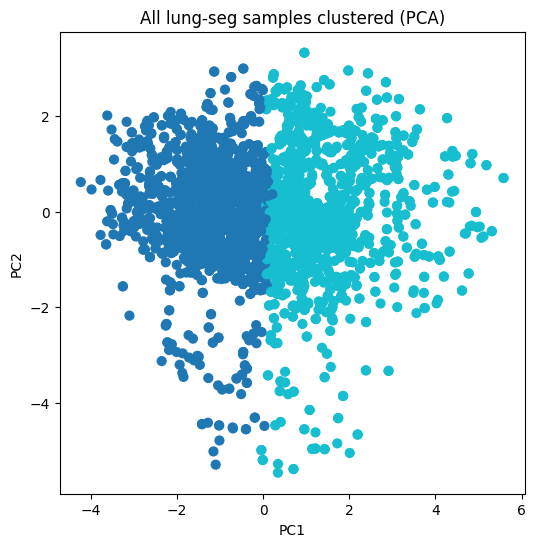

In [13]:
# 7) PCA for visualization
pca = PCA(n_components=2)
proj = pca.fit_transform(X)

plt.figure(figsize=(6,6))
plt.scatter(proj[:,0], proj[:,1], c=labels, s=40, cmap='tab10')
plt.title("All lung-seg samples clustered (PCA)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()